In [1]:
import numpy as np
import pandas as pd
import data_colleting as dc
from sklearn.model_selection import train_test_split

In [4]:
current_datetime = pd.to_datetime('today').normalize()
instrument_1 = "SBER"
instrument_2 = "VTBR"
finam = dc.Finam(instrument_1, instrument_2)

In [9]:
sber_data, vtbr_data = finam.get_pair_data(current_datetime - pd.DateOffset(months=1), current_datetime)

ticker=SBER; period=2; start=2023/Jun/12; end=2023/Jul/12
ticker=VTBR; period=2; start=2023/Jun/12; end=2023/Jul/12


In [80]:
sber_df, vtbr_df = pd.DataFrame(data=list(map(lambda x: x.decode('utf-8').rstrip('\r\n').split(';'), sber_data[1:])),
                                        columns=sber_data[0].decode('utf-8').rstrip('\r\n').split(';')), \
    pd.DataFrame(data=list(map(lambda x: x.decode('utf-8').rstrip('\r\n').split(';'), vtbr_data[1:])), columns=vtbr_data[0].decode('utf-8').rstrip('\r\n').split(';'))

In [81]:
sber_df.rename(columns={"<DATE>": "DATE",
                          "<TIME>": "TIME",
                          "<OPEN>": "OPEN",
                          "<HIGH>":"HIGH",
                          "<LOW>": "LOW",
                          "<CLOSE>": "CLOSE",
                          "<VOL>": "VOL"}, inplace=True)
vtbr_df.rename(columns={"<DATE>": "DATE",
                          "<TIME>": "TIME",
                          "<OPEN>": "OPEN",
                          "<HIGH>":"HIGH",
                          "<LOW>": "LOW",
                          "<CLOSE>": "CLOSE",
                          "<VOL>": "VOL"}, inplace=True)

In [82]:
sber_df.head()

,<TICKER>,<PER>,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL
0,SBER,1,20230613,100000,241.5100000,241.7000000,241.2700000,241.4300000,371700
1,SBER,1,20230613,100100,241.4800000,241.6100000,241.0500000,241.0800000,279380
2,SBER,1,20230613,100200,241.0500000,241.1700000,240.8100000,241.0700000,162740
3,SBER,1,20230613,100300,241.0600000,241.4000000,241.0400000,241.3900000,75750
4,SBER,1,20230613,100400,241.3900000,241.4400000,241.3700000,241.4100000,80340


In [83]:
sber_df, vtbr_df = sber_df.drop(['<TICKER>', '<PER>'], axis=1), vtbr_df.drop(['<TICKER>', '<PER>'], axis=1)

In [84]:
sber_df['DATETIME'], vtbr_df['DATETIME'] = pd.to_datetime(sber_df["DATE"] + sber_df['TIME']), pd.to_datetime(vtbr_df['DATE'] + vtbr_df['TIME'])

In [85]:
sber_df = sber_df.drop(['DATE', 'TIME'], axis=1)
vtbr_df = vtbr_df.drop(['DATE', 'TIME'], axis=1)

In [87]:
sber_df.iloc[:, :-1] = sber_df.iloc[:, :-1].astype(float)
vtbr_df.iloc[:, :-1] = vtbr_df.iloc[:, :-1].astype(float)

In [88]:
sber_df.head()

,OPEN,HIGH,LOW,CLOSE,VOL,DATETIME
0,241.51,241.7,241.27,241.43,371700.0,2023-06-13 10:00:00
1,241.48,241.61,241.05,241.08,279380.0,2023-06-13 10:01:00
2,241.05,241.17,240.81,241.07,162740.0,2023-06-13 10:02:00
3,241.06,241.4,241.04,241.39,75750.0,2023-06-13 10:03:00
4,241.39,241.44,241.37,241.41,80340.0,2023-06-13 10:04:00


In [91]:
sber_df['AVG'] = sber_df[['OPEN', 'CLOSE']].mean(axis=1)
vtbr_df['AVG'] = vtbr_df[['OPEN', 'CLOSE']].mean(axis=1)

In [92]:
sber_df_avg = sber_df[['AVG', 'VOL', 'DATETIME']]
vtbr_df_avg = vtbr_df[['AVG', 'VOL', 'DATETIME']]

In [99]:
df = sber_df_avg.merge(vtbr_df_avg, on='DATETIME', suffixes=['_sber', '_vtbr'])

In [102]:
df['diff'] = df['AVG_sber'] - df['AVG_vtbr']

In [103]:
df['z-score'] = (df['diff'] - df['diff'].mean()) / df['diff'].std()

In [193]:
spread_avg60 = df['z-score'].rolling(window=60, center=False).mean()
spread_avg180 = df['z-score'].rolling(window=200, center=False).mean()
spread_std180 = df['z-score'].rolling(window=200, center=False).std()
zscore_60_120 = (spread_avg60 - spread_avg180) / spread_std180

In [194]:
conditions = [(zscore_60_120 < 1.20) & (zscore_60_120 > -1.20),
              (zscore_60_120 >= 1.20),
              (zscore_60_120 <= -1.20)]
values = [0, -1, 1]

In [190]:
df_avg = df.copy()

In [195]:
df_avg['indicator'] = np.select(conditions, values)

In [185]:
conditions_nonavg = [(df['z-score'] < 1.25) & (df['z-score'] > -1.25),
              (df['z-score'] >= 1.25),
              (df['z-score'] <= -1.25)]

In [186]:
df['indicator'] = np.select(conditions_nonavg, values)

In [154]:
import matplotlib.pyplot as plt

(233.818515, 249.6870125)

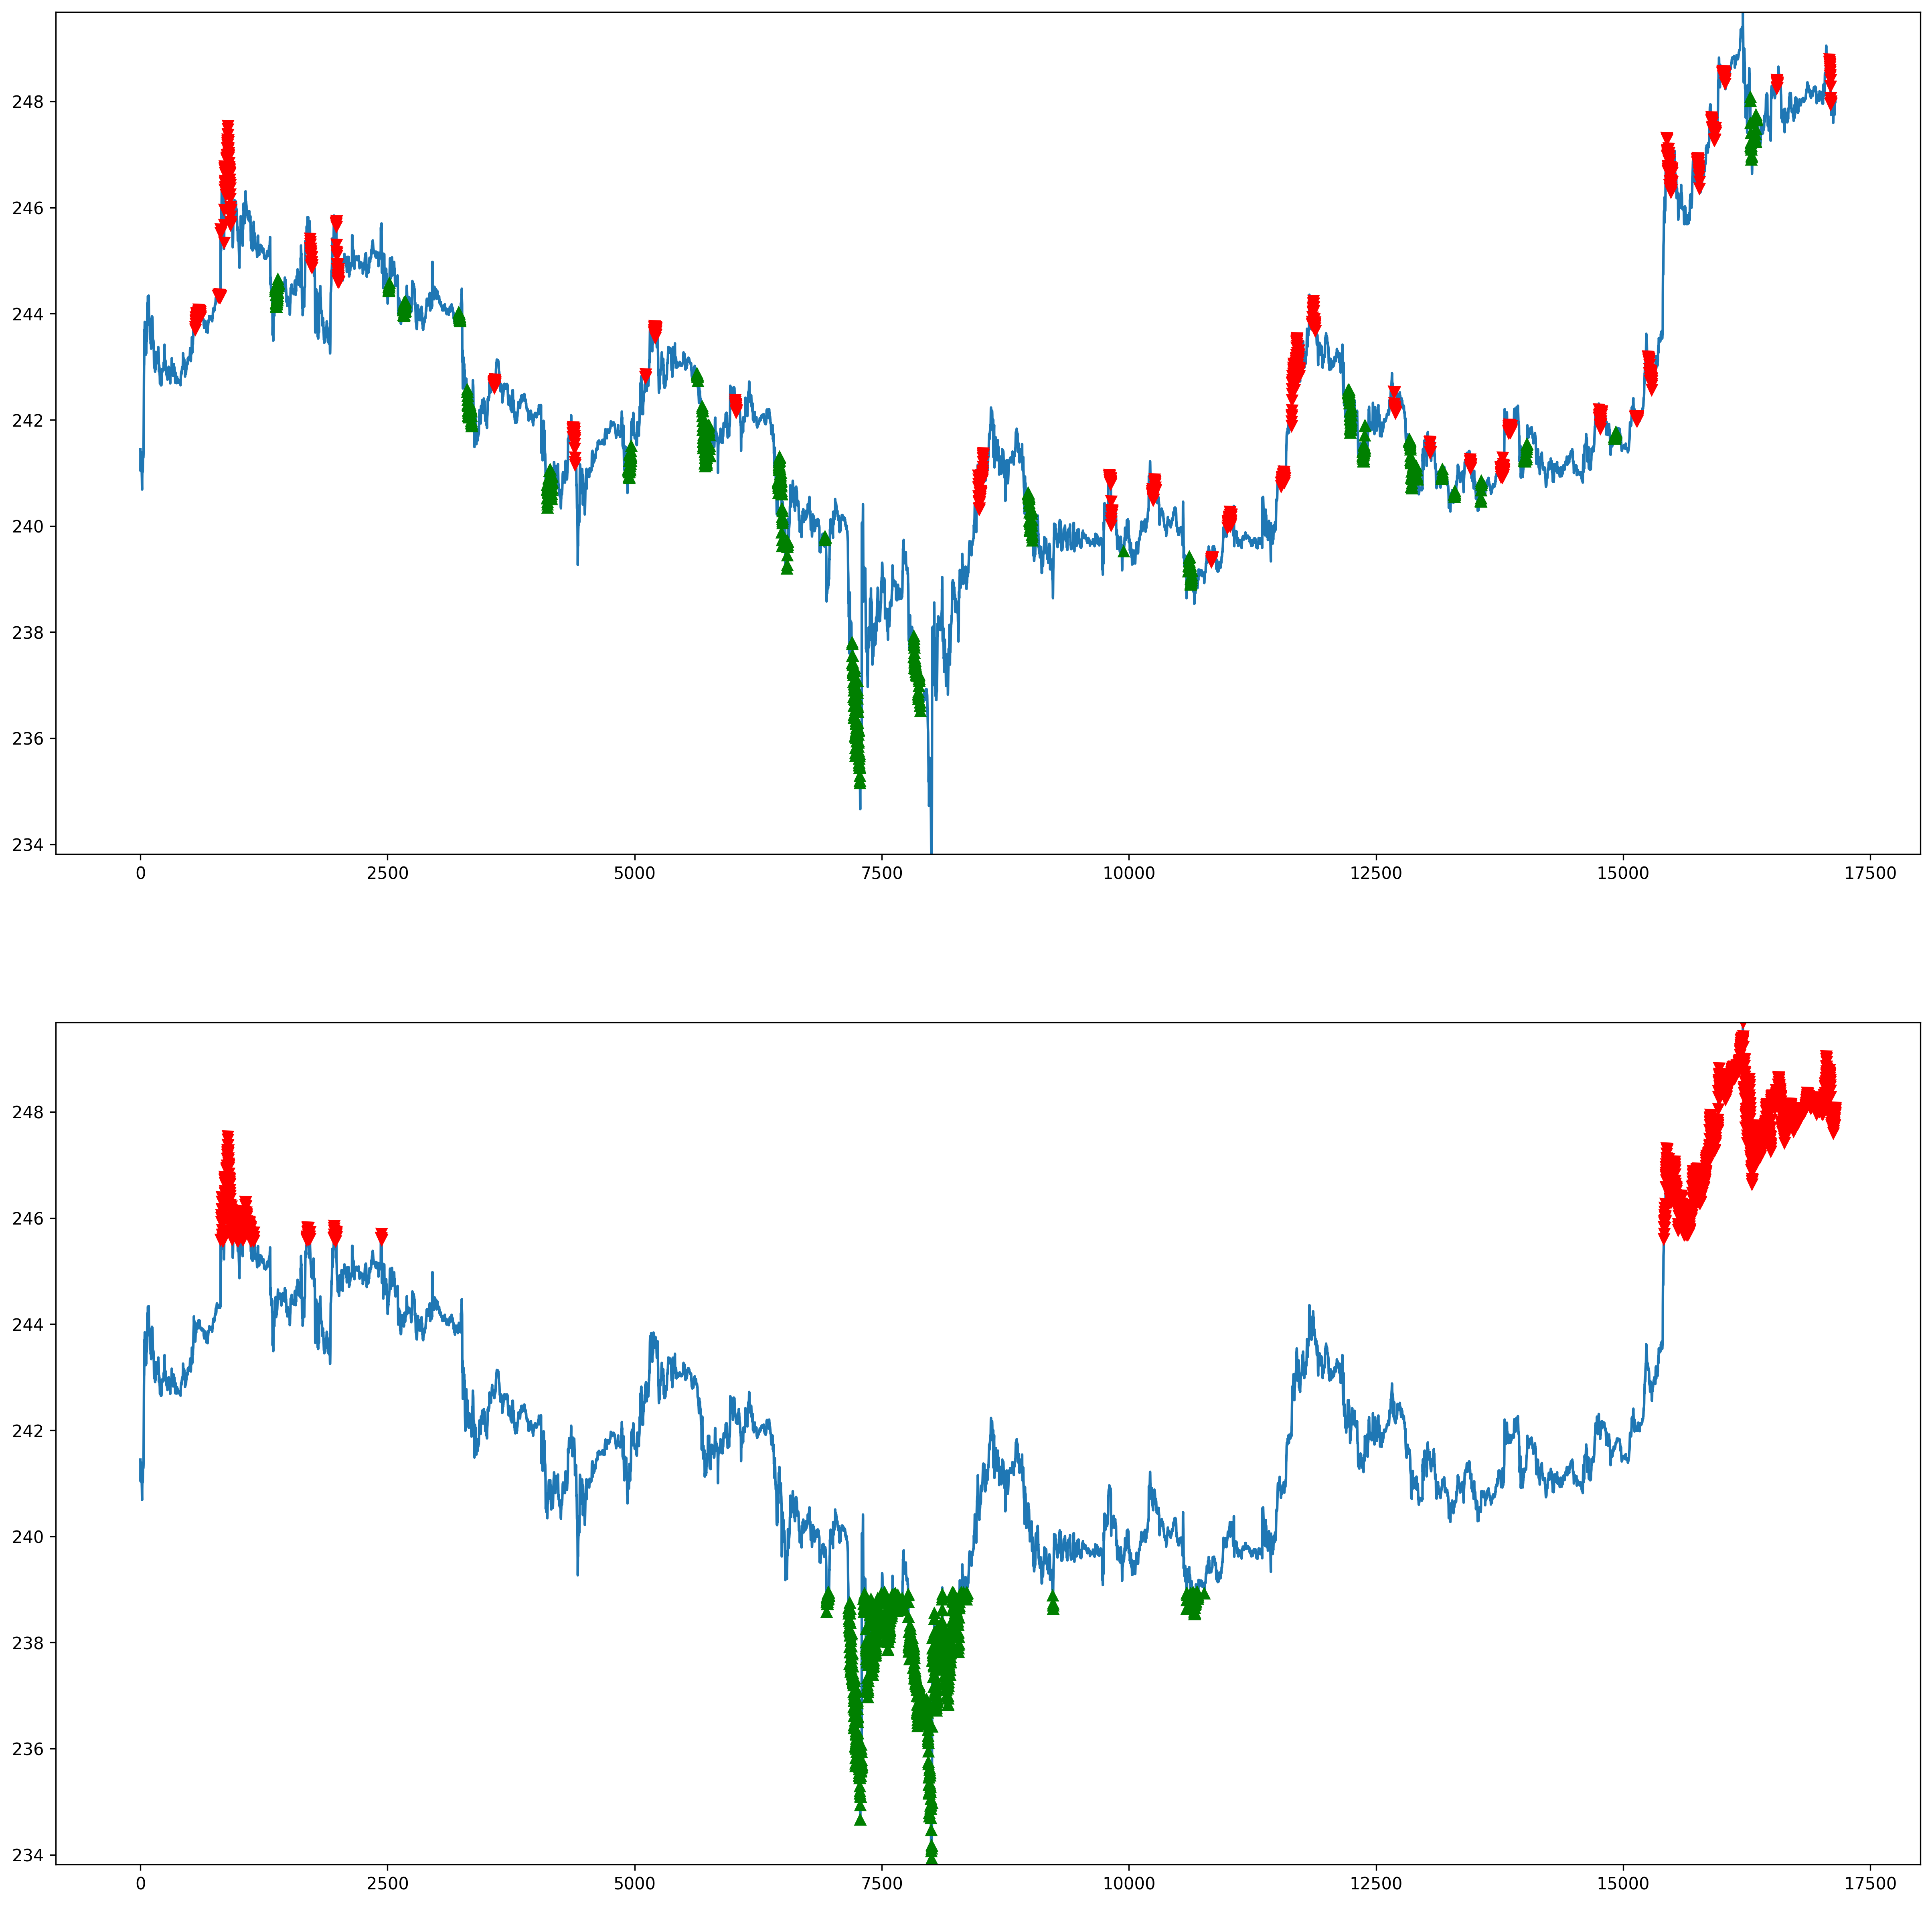

In [196]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(20,20,), dpi=300)
axes[0].plot(df.index, df['diff'])
axes[1].plot(df.index, df['diff'])
buy, sell = df['diff'].copy(), df['diff'].copy()
buy[df_avg['indicator'] != 1] = 0
sell[df_avg['indicator'] != -1] = 0
axes[0].plot(buy, linestyle='None', color='g', marker='^')
axes[0].plot(sell, linestyle='None', color='r', marker='v')
axes[0].set_ylim(bottom=df_avg['diff'].min(), top=df_avg['diff'].max())

buy_n, sell_n = df['diff'].copy(), df['diff'].copy()
buy_n[df['indicator'] != 1] = 0
sell_n[df['indicator'] != -1] = 0
axes[1].plot(buy_n, linestyle='None', color='g', marker='^')
axes[1].plot(sell_n, linestyle='None', color='r', marker='v')
axes[1].set_ylim(bottom=df_avg['diff'].min(), top=df_avg['diff'].max())

In [215]:
X_train, X_test, y_train, y_test = train_test_split(df_avg[['AVG_sber', 'AVG_vtbr', 'diff', 'VOL_sber', 'VOL_vtbr']], df_avg['indicator'], train_size=0.8, test_size=0.2, random_state=None, shuffle=False)

In [209]:
from sklearn.preprocessing import StandardScaler

In [216]:
scale = StandardScaler()
X_train[['AVG_sber', 'AVG_vtbr', 'diff', 'VOL_sber', 'VOL_vtbr']] = scale.fit_transform(X_train[['AVG_sber', 'AVG_vtbr', 'diff', 'VOL_sber', 'VOL_vtbr']])
X_test[['AVG_sber', 'AVG_vtbr', 'diff', 'VOL_sber', 'VOL_vtbr']] = scale.transform(X_test[['AVG_sber', 'AVG_vtbr', 'diff', 'VOL_sber', 'VOL_vtbr']])

In [218]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

In [219]:
# Метод опорных векторов
svm = SVC()
cv = cross_val_score(svm, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.78061224, 0.90014577, 0.85568513, 0.89938024, 0.89938024]),
 0.8670407259825966)

In [220]:
# Логистическая регрессия
lr = LogisticRegression()
cv = cross_val_score(lr, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.90706997, 0.89905248, 0.88994169, 0.89901568, 0.89755742]),
 0.8985274470185971)

In [224]:
# K-nn
knn = KNeighborsClassifier(n_neighbors=20)
cv = cross_val_score(knn, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.58600583, 0.86297376, 0.85240525, 0.80532264, 0.73058695]),
 0.7674588855384872)

In [225]:
# Рандомные деревья
rfc = RandomForestClassifier(random_state=100)
cv = cross_val_score(rfc, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.5196793 , 0.76494169, 0.85313411, 0.79693766, 0.73641998]),
 0.7342225479327714)

In [226]:
gpc = GaussianProcessClassifier()
cv = cross_val_score(gpc, X_train, y_train, cv=5)
cv, cv.mean()


KeyboardInterrupt

